# Introduction

The goal of this model is to reliably predict the activity done by the subjects based on the motion sensor data. The motion data collected in this dataset was from an iPhone, which collects the same types of motion data as an Apple Watch.

For some additional info on this dataset, [here is this git repo](https://github.com/mmalekzadeh/motion-sense):

24 subjects (male and female) were asked to do 6 different activities over 15 trials. The motion sensor data was collected with an iPhone 6s at a 50 Hz sample rate. The six activities done by the partticipants were the following, along with their abbreviation used in this dataset:

- dws: downstairs
- ups: upstairs
- sit: sitting
- std: standing
- wlk: walking
- jog: jogging

Of the 15 trials, the first 9 were "long" trials, while the trials 11-16 were the "short" version of their respective activity. Trial-ID 10 was left out. The trials in order were the following:

- 1: dws
- 2: dws
- 3: ups
- 4: ups
- 5: sit
- 6: std
- 7: wlk
- 8: wlk
- 9: jog
- 11: dws
- 12: ups
- 13: sit
- 14: std
- 15: wlk
- 16: jog


# Setup

In [1]:
# Importing libraries and setting the path.

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

path = '/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/'

In [2]:
# Setting up lists for importing the data.

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the directories and appending the dataframes for each subject in each of the trials to a list for further use.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[6].split('_')[0]
        k['trial'] = int(i.split('/')[6].split('_')[1])
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)

# Creating one big dataframe (df) from the list of all individual dataframes. Dropping unnecessary columns and renaming the ones for rotation.

df = pd.concat(list_of_dfs).set_index('time')
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

In [3]:
df

,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,subject,activity,trial
time,,,,,,,,,,
0,0.454819,1.052780,-0.108917,1.151985,-0.055552,0.296486,-0.517680,16,dws,1
1,0.376831,0.929001,-0.066894,1.004748,-0.160723,0.148822,-0.528907,16,dws,1
2,0.321427,0.825241,0.012176,0.885712,-0.125106,0.032462,-0.498599,16,dws,1
3,0.286941,0.789627,0.009613,0.840201,0.135182,-0.113719,-0.398317,16,dws,1
4,0.284058,0.843247,-0.051727,0.891308,0.475710,-0.107196,-0.194053,16,dws,1
...,...,...,...,...,...,...,...,...,...,...
6859,0.101487,1.568817,-0.151886,1.579416,0.047839,-0.205053,-0.354167,7,wlk,7
6860,-0.389420,1.524643,0.047653,1.574311,-0.498880,0.069946,-0.452342,7,wlk,7
6861,-0.261795,1.058045,0.002655,1.089955,-0.519771,0.242518,0.098493,7,wlk,7


In [4]:
# Separating the dataframe into a training set and a test set. Making the cut between the long (1-9) and the short trials (11-16), with the short trials including one of each activity.

train_df = df[(df.trial < 10)]
test_df = df[(df.trial > 10)]

# Creating the features X and the targets y out of the training dataframe. Features are the seven columns for accelerometer (x,y,z,norm) and gyroscope (x,y,z).

X = train_df.iloc[:,:-3]
y = train_df.activity

A problem lies within the distribution of rows for each activity during the short trials (11-16), aka our test set:

In [5]:
test_df.activity.value_counts()

sit    104121
std     81611
wlk     65272
jog     29904
ups     28009
dws     22502
Name: activity, dtype: int64

Sitting and standing were done significantly longer than the other trials (it's the same during in the training set), so this has to be considered when evaluating models on the test set, as the easy to predict categories artificially boost the overall accuracy. I will evaluate models on each category individually and will not give too much weight on the overall accuracy, but approach would be to remove some data such that each activity has equal rows.

Let's try another model.

In [6]:
# Creating a neural network with the keras library.

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

# Using LabelEncoder to convert the targets (6 activities) by one-hot-encoding to a binary matrix (dummy_y).

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

dummy_y = np_utils.to_categorical(encoded_y)


In [7]:
# Creating the nueral network model.

model = Sequential()
model.add(Dense(80, input_dim=7, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_X, val_X, train_y, val_y = train_test_split(X, dummy_y, shuffle=True)

Epoch 1/10
4056/4056 [==============================] - 17s 4ms/step - loss: 0.6116 - accuracy: 0.7516 - val_loss: 0.5865 - val_accuracy: 0.7639
Epoch 2/10
4056/4056 [==============================] - 15s 4ms/step - loss: 0.5645 - accuracy: 0.7752 - val_loss: 0.5734 - val_accuracy: 0.7692
Epoch 3/10
4056/4056 [==============================] - 14s 4ms/step - loss: 0.5532 - accuracy: 0.7806 - val_loss: 0.5593 - val_accuracy: 0.7795
Epoch 4/10
4056/4056 [==============================] - 14s 3ms/step - loss: 0.5483 - accuracy: 0.7833 - val_loss: 0.5620 - val_accuracy: 0.7793
Epoch 5/10
4056/4056 [==============================] - 14s 3ms/step - loss: 0.5440 - accuracy: 0.7859 - val_loss: 0.5457 - val_accuracy: 0.7850
Epoch 6/10
4056/4056 [==============================] - 14s 3ms/step - loss: 0.5408 - accuracy: 0.7874 - val_loss: 0.5508 - val_accuracy: 0.7823
Epoch 7/10
4056/4056 [==============================] - 14s 4ms/step - loss: 0.5381 - accuracy: 0.7888 - val_loss: 0.5425 - val_ac

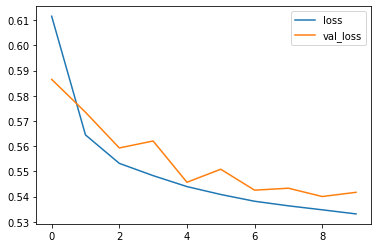

In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=200, validation_data=(val_X, val_y))
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

To evaluate the model on the test set with a list of accuracy for each activity, I need another function to do the one-hot-encoding on the targets and the decoding afterwards (with np.argmax on the predictions).

In [9]:
def get_test_results(model, df):
    """
    
    Parameters
    ----------
    model : tf.keras.Sequential()
        a model in form of a convolutional neural network, Sequential used here
    
    df : pd.DataFrame
        a dataframe on which the model makes predictions, including the activity column as target

    Returns
    -------
        prints out a list of the accuracy of the model on the dataframe for each activity

    """    
    correct = 0
    total = 0
    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        preds = model.predict(k)
        encoder = LabelEncoder()
        encoder.fit(df.activity)
        l = []
        for j in range(len(preds)):
            l.append(list(encoder.classes_)[np.argmax(preds[j])])
        accuracy = sum([l[j] == i for j in range(len(l))])/len(l)
        print(i + ': ' + str(accuracy*100) + '%')
        correct += sum([l[j] == i for j in range(len(l))])
        total += len(l)
    print('total: ' + str(correct / total * 100) + '%')

In [10]:
get_test_results(model, test_df)

dws: 34.33472580215092%
ups: 29.533364275768502%
sit: 94.78011160092585%
std: 93.81088333680509%
wlk: 78.05797279078318%
jog: 64.73381487426431%
total: 78.91883084554597%


I could probably improve this model by better tuning the hyperparametes, but there is a fundamental issue: **this network only takes in one frame (1/50th of a second) of data to make its decisions**

To solve this problem, I will instead feed the model the last few frames of data, which are known as "Lag Features"

# Lag Features

The idea is to have info from consecutive points in time in one row. To achieve this, I use lag features to copy one feature into a new column and shift it one or more rows down. Depending on the amount n of lag features, the dataframe gets n additional columns with n shifts in time.

It would probably be ideal to have a very high number of lag features and train the model over a longer period of time, but Kaggle computation is limited.

In [11]:
def create_lag_features(n, cols):
    """

    Parameters
    ----------
    n : int
        amount of lag features
    cols : list
        list of columns to lag

    Returns
    -------
    pd.DataFrame
        a dataframe with the list of columns lagged n times

    """

    lag_features = n
    lag_df = df.copy()

    for j in cols:
        for i in range(lag_features):
            lag_df.insert(7+i, j + '_lag' + str(i+1), lag_df[j].shift(i+1))
        
    # Dropping all rows where the lag overlapped two different subjects/trials (n timeframes at the beginning of every trial).

    for i in range(lag_features):
        lag_df = lag_df.drop([i])
    
    return lag_df

In [12]:
lag_df = create_lag_features(50, ['accel_norm'])
lag_df.head()

,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,accel_norm_lag1,accel_norm_lag2,accel_norm_lag3,...,accel_norm_lag44,accel_norm_lag45,accel_norm_lag46,accel_norm_lag47,accel_norm_lag48,accel_norm_lag49,accel_norm_lag50,subject,activity,trial
time,,,,,,,,,,,,,,,,,,,,,
50,0.130737,0.636841,0.025208,0.650611,1.135523,-0.807769,0.192803,0.728929,0.798274,0.982435,...,0.825510,0.825510,0.891308,0.840201,0.885712,1.004748,1.151985,16,dws,1
51,0.093628,0.609055,-0.068696,0.620027,1.576694,-0.883927,0.473720,0.650611,0.728929,0.798274,...,0.612106,0.825510,0.825510,0.891308,0.840201,0.885712,1.004748,16,dws,1
52,0.041718,0.671433,-0.156692,0.690735,2.215764,-0.635747,0.725694,0.620027,0.650611,0.728929,...,0.746748,0.612106,0.825510,0.825510,0.891308,0.840201,0.885712,16,dws,1
53,-0.072861,0.664520,-0.209060,0.700430,2.916685,-0.277571,0.856181,0.690735,0.620027,0.650611,...,0.746747,0.746748,0.612106,0.825510,0.825510,0.891308,0.840201,16,dws,1
54,-0.130996,0.597657,-0.197174,0.642831,2.889665,-0.057207,0.916598,0.700430,0.690735,0.620027,...,0.866394,0.746747,0.746748,0.612106,0.825510,0.825510,0.891308,16,dws,1


In [13]:
# Training and test sets with lag and the corresponding features and targets.

lag_train_df = lag_df[(lag_df.trial < 10)]
lag_test_df = lag_df[(lag_df.trial > 10)]

lag_X = lag_train_df.iloc[:,:-3]
lag_y = lag_train_df.activity

In [14]:
# Neural network for lag features.

import tensorflow as tf

lag_features = 50

lag_model = Sequential()
lag_model.add(Dense(64, input_dim=7+lag_features, activation='relu'))
lag_model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
lag_model.add(Dense(16, activation='relu'))
lag_model.add(Dense(6, activation='softmax'))

lag_opt = keras.optimizers.Adam(learning_rate=0.01)

lag_model.compile(loss='categorical_crossentropy', optimizer=lag_opt, metrics=['accuracy'])

In [15]:
# Encoding the targets by one-hot-encoding to a binary matrix (lag_dummy_y).

lag_encoder = LabelEncoder()
lag_encoder.fit(lag_y)
lag_encoded_y = lag_encoder.transform(lag_y)

lag_dummy_y = np_utils.to_categorical(lag_encoded_y)

lag_train_X, lag_val_X, lag_train_y, lag_val_y = train_test_split(lag_X, lag_dummy_y, shuffle=True)

Epoch 1/10
4015/4015 [==============================] - 19s 5ms/step - loss: 0.4391 - accuracy: 0.8507 - val_loss: 0.3465 - val_accuracy: 0.8845
Epoch 2/10
4015/4015 [==============================] - 19s 5ms/step - loss: 0.3360 - accuracy: 0.8889 - val_loss: 0.3207 - val_accuracy: 0.8936
Epoch 3/10
4015/4015 [==============================] - 18s 4ms/step - loss: 0.3192 - accuracy: 0.8954 - val_loss: 0.3208 - val_accuracy: 0.8944
Epoch 4/10
4015/4015 [==============================] - 19s 5ms/step - loss: 0.3112 - accuracy: 0.8982 - val_loss: 0.3118 - val_accuracy: 0.8981
Epoch 5/10
4015/4015 [==============================] - 16s 4ms/step - loss: 0.3063 - accuracy: 0.9003 - val_loss: 0.3026 - val_accuracy: 0.9024
Epoch 6/10
4015/4015 [==============================] - 16s 4ms/step - loss: 0.3013 - accuracy: 0.9022 - val_loss: 0.2944 - val_accuracy: 0.9048
Epoch 7/10
4015/4015 [==============================] - 16s 4ms/step - loss: 0.2992 - accuracy: 0.9030 - val_loss: 0.2845 - val_ac

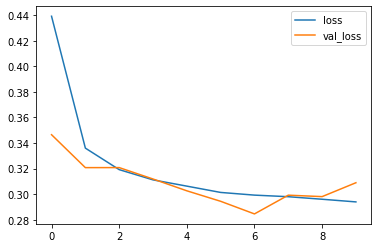

In [16]:
history = lag_model.fit(lag_train_X, lag_train_y, epochs=10, batch_size=200, validation_data=(lag_val_X, lag_val_y))
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [17]:
get_test_results(lag_model, lag_test_df)

dws: 60.548305323443806%
ups: 80.058935432131%
sit: 77.72563422430795%
std: 95.8401213764286%
wlk: 90.60900237233113%
jog: 94.6383779264214%
total: 85.3259679414223%


The lag features clearly improved the results a lot. But 90% accuracy still does not really meet the bar for a motion sensing model, so I need to take another approach. Before moving on from the lag features, I will see the confusion matrix of the results from this model.

In [18]:
# Quick function for generating a list of the predictions to compare with the targets, instead of a matrix of their probabilities.

def get_pred_list(model, df):
    """
    
    Parameters
    ----------
    model : tf.keras.Sequential()
        a model in form of a convolutional neural network, Sequential used here
    
    df : pd.DataFrame
        a dataframe on which the model makes predictions, including the activity column as target

    Returns
    -------
    l : list
        a list of the encrypted predictions of the model
    
    y : pd.Series
        the target vector to compare with the prediction list
    
    """
    l = []
    X = df.iloc[:,:-3]
    y = df.activity
    preds = model.predict(X)
    encoder = LabelEncoder()
    encoder.fit(y)
    for i in range(len(preds)):
        l.append(list(encoder.classes_)[np.argmax(preds[i])])
    return l, y

In [19]:
lag_pred, lag_y = get_pred_list(lag_model, lag_test_df)

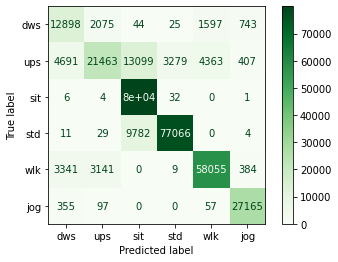

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(lag_pred, lag_y, labels=activities)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=activities)
conf_mat_disp.plot(cmap='Greens')
plt.show()

# Rolling Features

My next approach is with rolling features, which are similar to lag features in the way that they incorporate past data. However, rolling features represent allow a mean, median, standard deviation or other mathematical function on a vector of past frames. This allows the model to process n rows of preceding data with only 1 column, rather than n columns! This makes much better use of the computation power available in Kaggle.


In [21]:
# Creating rolling feature columns.

def create_rolling_feature_columns(k):
    """
    
    Parameters
    ----------
    k : int
        the amount of steps for the rolling features

    Returns
    -------
    pd.Dataframe
        a new dataframe with rolling features over k steps

    """
    
    feat_df = df.copy()
    cols = feat_df.iloc[:,:-3].columns

    j = 1
    for i in cols:
        feat_df.insert(j, f'{i}_rmean', feat_df[i].rolling(k).mean())
        feat_df.insert(j+1, f'{i}_rstd', feat_df[i].rolling(k).std())
        feat_df.insert(j+2, f'{i}_rmed', feat_df[i].rolling(k).median())
        # other functions not used but experimented with
        #feat_df.insert(j+3, f'{i}_rskew', feat_df[i].rolling(k).skew()) 
        #feat_df.insert(j+4, f'{i}_rmax', feat_df[i].rolling(k).max())
        #feat_df.insert(j+5, f'{i}_rmin', feat_df[i].rolling(k).min())
        #feat_df.insert(j+6, f'{i}_squared', feat_df[i]**2)
        j += 4

    # Dropping all rows where the lag overlapped two different subjects/trials.

    for i in range(k):
        feat_df = feat_df.drop([i])
    
    return feat_df

In [22]:
feat_df = create_rolling_feature_columns(150) # look at the past 150 frames, or 3 seconds, of data

In [23]:
feat_df

,accel_x,accel_x_rmean,accel_x_rstd,accel_x_rmed,accel_y,accel_y_rmean,accel_y_rstd,accel_y_rmed,accel_z,accel_z_rmean,...,gyro_y_rmean,gyro_y_rstd,gyro_y_rmed,gyro_z,gyro_z_rmean,gyro_z_rstd,gyro_z_rmed,subject,activity,trial
time,,,,,,,,,,,,,,,,,,,,,
150,-0.252700,0.266308,0.290877,0.285499,0.778031,0.912268,0.439799,0.815392,-0.150726,-0.250131,...,0.034013,0.480562,0.030090,-0.005361,0.014811,0.804590,-0.040035,16,dws,1
151,-0.245972,0.262156,0.293720,0.281883,0.339157,0.908335,0.442278,0.811051,0.100784,-0.249013,...,0.030929,0.481304,0.022535,-0.268671,0.016546,0.803689,-0.040035,16,dws,1
152,-0.086731,0.259435,0.295054,0.276253,0.288132,0.904755,0.445120,0.809868,0.112000,-0.248348,...,0.029163,0.481784,0.016206,-0.365836,0.017431,0.803191,-0.040035,16,dws,1
153,0.032562,0.257739,0.295626,0.272629,0.448700,0.902482,0.446580,0.809868,0.052536,-0.248062,...,0.026189,0.484044,0.016206,-0.313615,0.017996,0.802927,-0.040035,16,dws,1
154,0.327210,0.258027,0.295672,0.272629,2.036118,0.910434,0.456039,0.809868,0.216187,-0.246276,...,0.022567,0.487073,0.016206,-0.222199,0.017809,0.802980,-0.040035,16,dws,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,0.101487,-0.024802,0.239415,0.019738,1.568817,1.006227,0.406361,0.975129,-0.151886,-0.026296,...,-0.103489,0.711646,-0.013985,-0.354167,0.139480,0.963486,-0.094505,7,wlk,7
6860,-0.389420,-0.026792,0.241202,0.019738,1.524643,1.009447,0.408551,0.975129,0.047653,-0.026352,...,-0.105814,0.710497,-0.013985,-0.452342,0.140182,0.963013,-0.094505,7,wlk,7
6861,-0.261795,-0.027678,0.241823,0.019738,1.058045,1.009138,0.408496,0.975129,0.002655,-0.026852,...,-0.108328,0.708578,-0.013985,0.098493,0.144218,0.961550,-0.081249,7,wlk,7


In [24]:
feat_train_df = feat_df[(feat_df.trial < 10)]
feat_test_df = feat_df[(feat_df.trial > 10)]

feat_X = feat_train_df.iloc[:,:-3]
feat_y = feat_train_df.activity

In [25]:
# Nueral network model for feature df:

import tensorflow as tf
from keras.layers import Dropout

extra_features = 3 # 3 mathematical operations on each feature's past 3 seconds of data

roll_model = Sequential()
roll_model.add(Dense(64, input_dim=7+7*extra_features, activation='relu'))
roll_model.add(Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
roll_model.add(Dropout(0.2))
roll_model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
roll_model.add(Dropout(0.5))
roll_model.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
roll_model.add(Dense(6, activation='softmax'))

roll_opt = keras.optimizers.Adam(learning_rate=0.01)

roll_model.compile(loss='categorical_crossentropy', optimizer=roll_opt, metrics=['accuracy'])

In [27]:
roll_encoder = LabelEncoder()
roll_encoder.fit(feat_y)
roll_encoded_y = roll_encoder.transform(feat_y)

roll_dummy_y = np_utils.to_categorical(roll_encoded_y)

feat_train_X, feat_val_X, feat_train_y, feat_val_y = train_test_split(feat_X, roll_dummy_y, shuffle=True, random_state=0)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

Epoch 1/20
3934/3934 [==============================] - 21s 5ms/step - loss: 0.3424 - accuracy: 0.9332 - val_loss: 0.2035 - val_accuracy: 0.9758
Epoch 2/20
3934/3934 [==============================] - 19s 5ms/step - loss: 0.2413 - accuracy: 0.9623 - val_loss: 0.1824 - val_accuracy: 0.9772
Epoch 3/20
3934/3934 [==============================] - 18s 4ms/step - loss: 0.2215 - accuracy: 0.9656 - val_loss: 0.1779 - val_accuracy: 0.9765
Epoch 4/20
3934/3934 [==============================] - 18s 5ms/step - loss: 0.2156 - accuracy: 0.9664 - val_loss: 0.1535 - val_accuracy: 0.9809
Epoch 5/20
3934/3934 [==============================] - 17s 4ms/step - loss: 0.2099 - accuracy: 0.9668 - val_loss: 0.1767 - val_accuracy: 0.9788
Epoch 6/20
3934/3934 [==============================] - 18s 5ms/step - loss: 0.2073 - accuracy: 0.9665 - val_loss: 0.1420 - val_accuracy: 0.9824
Epoch 7/20
3934/3934 [==============================] - 17s 4ms/step - loss: 0.2055 - accuracy: 0.9664 - val_loss: 0.1448 - val_ac

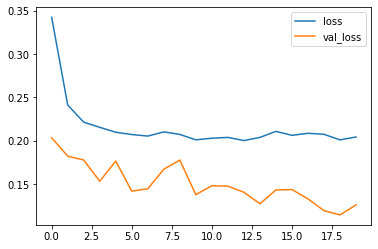

In [29]:
history = roll_model.fit(feat_train_X, feat_train_y, epochs=20, batch_size=200, validation_data=(feat_val_X, feat_val_y), callbacks=[early_stopping])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [30]:
get_test_results(roll_model, feat_test_df)

dws: 98.57687017246852%
ups: 94.00630914826499%
sit: 100.0%
std: 95.83904833933676%
wlk: 93.76864703593203%
jog: 94.29364355231144%
total: 96.66837734290021%


Best test result: (results varied with the same model given the random nature of training)

(rolling 150 / 7 + 21 features / 5 layer (64-48-32-16-6) / all relu activations / 3 * L2 Reg (0.2 + 0.1) / 2 * dropout (0.2 + 0.5) / batch_size=200 / early_stopping callback after 20 epochs)

dws: 98.57687017246852%  
ups: 94.00630914826499%  
sit: 100.0%  
std: 95.83904833933676%  
wlk: 93.76864703593203%  
jog: 94.29364355231144%  
total: 96.66837734290021%  

In [31]:
feat_pred, feat_targ = get_pred_list(roll_model, feat_test_df)

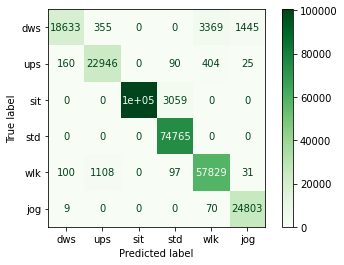

In [32]:
# Confusion Matrix:

conf_mat = confusion_matrix(feat_pred, feat_targ, labels=activities)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=activities)
conf_mat_disp.plot(cmap='Greens')
plt.show()

In [33]:
from tensorflow.keras.models import save_model

save_model(roll_model, '/kaggle/working/my_model.h5')

# Conclusion

I experimented with different amounts of layers, neurons in each layer, activation functions, and most importantly different methods of feeding past data through the model.